# Amazon Textract - Receipts Demo

In the following notebook, we will examine the use of Amazon Textract in order to perform optical character recognition (OCR), and then use a selection of libraries and Amazon Sagemaker's built-in Algorithms to organize, explore, and classify the dataset.

By the end of this notebook, you will have learnt:

- How to use Amazon Textract to ingest multiple images and obtain the results from the API
- How to interpret the Amazon Textract results
- How to use the Amazon Textract results in order to perform data exploration
- How to enrich raw OCR data with Entity Tags
- How to perform simple Feature Engineering to reduce large datasets
- How to use Amazon SageMaker to build Word Embeddings (Vector Space Representations) of your data




### **Contents:**
- Part 0 - Housekeeping
- Part 1 - Data Download and Amazon TExtract Enrichment
- Part 2 - Data Enrichment (NLTK/SPACY) and Exploration
    - 2.1 POS and NER
    - 2.2 Data Analysis
    - 2.3 Term Co-occerence
    - 2.4 Feature Analysis
    - 2.5 Word Embeddings

## Part 0. Housekeeping



### General Imports

These are the libraries which we will require in order to complete different types of operations.

Just a quick note, you may need to use ```nltk.download()``` in order to download the correct libraries and additional packages required to perform text tagging

In [287]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from matplotlib import pylab
import nltk 
import spacy
import en_core_web_lg
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer 
import string
import pickle
from nltk.corpus import stopwords 
from itertools import combinations 
import operator
from io import BytesIO
import tarfile
import seaborn as sns


### Constant Set-up
Configure all global constants here, these are variables which will remain constant throughout the execution of the notebook.

In [3]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'aws-demo-receipts',
    'prefix' : 'preprocessed_reviews', #only use this if you want to have your files in a folder 
    'dataset_path_s3' : 'receipts_data/',
    'training_data_prefix_s3' : 'training_data/',
    'output_data_s3' : 'output_data/',
    'dataset_zipped_filename': 'large-receipt-image-dataset-SRD.zip',
    'dataset_zipped_path':'data_zipped/',
    'tmp_folder':'tmp/',
    'stopwords_custom': 'stopwords_custom.txt'
   
}

global_vars = {}


### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [4]:
def setup_env(configs, global_vars):
   
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    
    #set up textract
    textract = boto3.client('textract')
    
    global_vars['textract'] = textract

    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


In [259]:
def setup_nlp(configs, global_vars):
    
    nlp = en_core_web_lg.load()
    global_vars['nlp'] = nlp
    stop_words = []
    with open(configs['stopwords_custom'], 'r') as file:
        for line in file:
            stop_words.append(line.strip())
    global_vars['stop_words'] = stop_words
    return global_vars

global_vars = setup_nlp(configs, global_vars)

## Part 1. Download Data and Perform OCR using Amazon Textract

Here we are goin to download the data to our bucket if it does not already exist. This dataset is a pre-compiled dataset of car images which contain 2 typers:

- Whole (e.g. without damage)
- Damaged (e.g. those with damage)

The following create_dataset method will first download the Zip of the data, and then unpack it to the bucket named in the global constants



In [4]:
def create_dataset(configs, global_vars):
    
    dataset_key = configs['dataset_path_s3']
    s3_bucket = global_vars['s3_bucket']
    objs = list(s3_bucket.objects.filter(Prefix=dataset_key))

    if len(objs) > 0 and objs[0].key == configs['dataset_zipped_filename']:
        exists = True
        print('{} Already Exists, No need to copy to S3 or Unzip'.format(dataset_key) )
    else:
        exists = False
    
    if not exists:
        
        data_path = configs['dataset_zipped_path'] + configs['dataset_zipped_filename']
        data_file_s3 = configs['dataset_path_s3'] + configs['dataset_zipped_filename']
        s3_bucket.upload_file(data_path, data_file_s3)

        s3 = boto3.client('s3', use_ssl=False)
        Key_unzip = configs['dataset_path_s3']

    
        s3_resource = boto3.resource('s3')
        #Now create zip object one by one, this below is for 1st file in file_list
        zip_obj = s3_resource.Object(bucket_name=bucket_name, key=data_file_s3)
        
        print('Unpacking {}\n'.format(data_file_s3))
        print (zip_obj)
        buffer = BytesIO(zip_obj.get()["Body"].read())
        z = zipfile.ZipFile(buffer)
        for filename in z.namelist():
            file_info = z.getinfo(filename)
            s3_resource.meta.client.upload_fileobj(
                z.open(filename),
                Bucket=bucket_name,
                Key=Key_unzip + f'{filename}')
            
        
    
# create_dataset(bucket_name, s3_bucket)

In [6]:
def test_textract(configs, global_vars, show_image = False):
    
    #first download a temp document
    tmp_folder = configs['tmp_folder']
    try:
        os.mkdir(tmp_folder)
    except:
        pass
    
    s3_bucket = global_vars['s3_bucket']
    s3 = global_vars['s3']
    
    s3_path = configs['dataset_path_s3']
    objs = list(s3_bucket.objects.filter(Prefix=s3_path))
    
    files_data = {}
    for entry in objs:
        print(entry.key)
        file_data = []
        if 'jpg' in entry.key:
            local_path = tmp_folder + 'tmp.jpg'
            s3.Bucket(configs['bucket_name']).download_file(str(entry.key), local_path)  
            
            with open(local_path, 'rb') as document:
                imageBytes = bytearray(document.read())
            
            response = global_vars['textract'].detect_document_text(Document={'Bytes': imageBytes})

            if show_image:
                raw_img = mpimg.imread(local_path)
                height, width, depth = raw_img.shape
                dpi = 80
                figsize = width / float(dpi), height / float(dpi)
                plt.figure(figsize = figsize)
                plt.imshow(raw_img, aspect='auto')

            files_data[entry.key] =  response
            
    return files_data


    
    
textract_data = test_textract(configs, global_vars)

receipts_data/
receipts_data/1000-receipt.jpg
receipts_data/1001-receipt.jpg
receipts_data/1002-receipt.jpg
receipts_data/1003-receipt.jpg
receipts_data/1004-receipt.jpg
receipts_data/1005-receipt.jpg
receipts_data/1006-receipt.jpg
receipts_data/1007-receipt.jpg
receipts_data/1008-receipt.jpg
receipts_data/1009-receipt.jpg
receipts_data/1010-receipt.jpg
receipts_data/1011-receipt.jpg
receipts_data/1012-receipt.jpg
receipts_data/1013-receipt.jpg
receipts_data/1014-receipt.jpg
receipts_data/1015-receipt.jpg
receipts_data/1016-receipt.jpg
receipts_data/1017-receipt.jpg
receipts_data/1018-receipt.jpg
receipts_data/1019-receipt.jpg
receipts_data/1020-receipt.jpg
receipts_data/1021-receipt.jpg
receipts_data/1022-receipt.jpg
receipts_data/1023-receipt.jpg
receipts_data/1024-receipt.jpg
receipts_data/1025-receipt.jpg
receipts_data/1026-receipt.jpg
receipts_data/1027-receipt.jpg
receipts_data/1028-receipt.jpg
receipts_data/1029-receipt.jpg
receipts_data/1030-receipt.jpg
receipts_data/1031-recei

### Useful Method if you want to resume a session if the kernal dies

In [8]:
def load_or_save_record_meta_data(textract_data=None, load_or_save='load'):
    
    tmp_filename = 'tmp.pickle'
    if load_or_save == 'load':
        with open(tmp_filename, 'rb') as handle:
            data = pickle.load(handle)
        return data

        
    if load_or_save == 'save':
        with open(tmp_filename, 'wb') as handle:
            pickle.dump(textract_data, handle, protocol=pickle.HIGHEST_PROTOCOL)  
        print('Saved to {}'.format(tmp_filename))
        return textract_data
    
textract_data = load_or_save_record_meta_data('', 'load')

## Part 2. Dataset Enrichment and Exploration

In this section, we're going to be exploring different analytical approaches to interpretting the receipt data. This is an important part of any data science driven experiment, as the exploration (and through the iterations of exploration), will help us derive the most useful insights for a given use case.

In [9]:
def inspect_dataset(textract_data):
    
    print('Total Records {}'.format(len(textract_data)))

inspect_dataset(textract_data)

Total Records 200


### 2.1 Process Data

Using Textract's repsponse, we look at each word in our data, and store it with it's confidence scores. Then a series of data enrichment processes take place.

Note, we use a filtering approach to ensure that we are not introducing random stop words..

#### Enriching the Textract Results

The Following methods will be used to enrich each of the records with additional information.

We're going to use two libraries to perform our enrichment, ```NLTK```, and ```Spacy```.

#### Part of Speech Tagging (POS)

In the world of Natural Language Processing (NLP), the most basic models are based on Bag of Words. But such models fail to capture the syntactic relations between words. ... POS tagging is the process of marking up a word in a corpus to a corresponding part of a speech tag, based on its context and definition.

For Part of Speak Tagging, we're using NLTK. More details can be found here:

https://www.nltk.org/api/nltk.tag.html

The tags which NLTK uses are as follows:

 - CD - cardinal numbers
 - AT -Articles
 - JJ - Adjectives
 - NN Nouns
 - NNS - Plural Nouns
 - RB - adverbs
 - VGB - gerunds
 - VBD - past tense verbs
 
#### Named Entity Recognition (NER)

Named-entity recognition (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

For our NER, spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products.

For More information on Spacey, please take a read here:



The Tags which Space use are as follows:

 - PERSON	People, including fictional.
 - NORP	Nationalities or religious or political groups.
 - FAC	Buildings, airports, highways, bridges, etc.
 - ORG	Companies, agencies, institutions, etc.
 - GPE	Countries, cities, states.
 - LOC	Non-GPE locations, mountain ranges, bodies of water.
 - PRODUCT	Objects, vehicles, foods, etc. (Not services.)
 - EVENT	Named hurricanes, battles, wars, sports events, etc.
 - WORK_OF_ART	Titles of books, songs, etc.
 - LAW	Named documents made into laws.
 - LANGUAGE	Any named language.
 - DATE	Absolute or relative dates or periods.
 - TIME	Times smaller than a day.
 - PERCENT	Percentage, including ”%“.
 - MONEY	Monetary values, including unit.
 - UANTITY	Measurements, as of weight or distance.
 - ORDINAL	“first”, “second”, etc.
 - CARDINAL	Numerals that do not fall under another type.



In [10]:
def process_textract_text(data, print_output= True):
    
    currencies = ['$',' £','€']
    
    values = []
    currency_values = []
    
    words = []
    
    UPPER_BOUND = 2000.0
    
    for line in data:
        #first see if it can be recognised as a value:
        if any(ext in line for ext in currencies):
            currency_values.append(line)
#             print(line)
        else:
            try:
                value = float(line)
                values.append(value)
            except:
                pass
            
        #now P O W taggig
        wrds = nltk.word_tokenize(line)
        words = words + wrds
    
    #nltk POS tagging
    nltk_tagged_words = nltk.pos_tag(words)
    
    #perform Spacy Analysis:
    spacey_enriched_words = spacey_enricher(global_vars, data)
    
    verbs = []
    nouns = []
    cds = []
    products = []
    locations = []
    organisations = []
    dates = []
    for entry in nltk_tagged_words:
#         print(entry)
        k = entry[0]

        v = entry[1]
        if v == 'NN' or v == 'NNS':
            nouns.append(k)
            
        if v == 'VBD' or v == 'VGB':
            verbs.append(k)
        
        if v == 'CD':
            cds.append(k)  
            
           
    #process SPACEY results
    for entry in spacey_enriched_words.ents:
        if entry.label_ is 'PRODUCT':
            products.append(entry.text)
        
        if entry.label_ is 'LOC':
            locations.append(entry.text)
        
        if entry.label_ is 'ORG':
            organisations.append(entry.text)
            
#         if entry.label_ is 'DATE':
#             dates.append(entry.text)
                    
    #calculate max cardinal values
    cds_float = []
    for value in cds:
        #firsr monetary values
        try:
            if ('.' in value):
                tmp = float(value)
                if tmp < UPPER_BOUND:
                    cds_float.append(tmp) 
        except:
            pass
       
        #now dates
        try:
            date_tmp = pd.to_datetime(str(value))
            #avoid the case where the hh:mm:ss is only found, and then pandas creates a date which is current day
            if date_tmp.date() != datetime.today().date():
                dates.append(str(date_tmp))
        except Exception as e:
            pass
            
    record_data = {}
    record_data['verbs'] = verbs
    record_data['nouns'] = nouns
    record_data['cardinals'] = cds
    record_data['products'] = products
    record_data['companies'] = organisations
    record_data['locations'] = locations
    record_data['dates'] = dates
    record_data['currency_values'] = dates
    record_data['values_raw'] = values
    record_data['tokens'] = words
    


    if len(cds_float) > 0:
        record_data['max_value'] = max(cds_float)
    else:
        record_data['max_value'] = 0


    
    if print_output:
         
        print('Currency Linked Value: {}'.format(currency_values))
        print('Raw Values: {}'.format(values))
    #     print('Tagged Words: {}'.format(nltk_tagged_words))
        print('Verbs: {}'.format(verbs))
        print('Nouns: {}'.format(nouns))
        print('Cardinal Values: {}'.format(cds))
        print('Products {}'.format(products))
        print('Companies {}'.format(organisations))
        print('Locations {}'.format(locations))
        print('Dates {}'.format(dates))
        print('MAX Value {}'.format( record_data['max_value']))
        print('\n ### \n')

    return record_data
    
        
    


In [11]:
def spacey_enricher(global_vars, words_list):
    string_of_words = ' '.join(map(str, words_list)) 
    
    string_of_words = string_of_words
#     print(string_of_words)
    doc = global_vars['nlp'](string_of_words)
    #returned with a list of entities (ents), which have k,v of (text, label_)
#     print([(X.text, X.label_) for X in doc.ents])
    return doc

In [260]:
def process_textract_responses(global_vars, data):
    stop_words = global_vars['stop_words']
    stop_words_nltk = stopwords.words('english')
    ps = PorterStemmer()
    exclude = set(string.punctuation)
    table = str.maketrans('', '', string.punctuation)

    records_enriched = {}
    removed_tokens = 0
    for key,response in data.items():
        line_data = []
        confidences = []
        for item in response["Blocks"]:
                if item["BlockType"] == "WORD":
                    
                    #we need to normailise and remove punctuation.
                    word = item["Text"].lower().strip().replace(',','').replace(':',''). \
                    replace('?','').replace('000','').replace('>','').replace('<','').replace('!',''). \
                    replace(')','').replace('(','').replace('#','')
                   
                    #now remove all punctuation
#                     if not word.isdigit():
#                     word = word.translate(table)
                    #we have some oddities
                    word =  ' '.join(i for i in word.split(' ') if not i.endswith('pm'))
                    word  = ' '.join(i for i in word.split(' ') if not i.endswith('am'))
            
                    word_stemmed = ps.stem(word)
                
                    if (word_stemmed not in stop_words) and (word not in stop_words) and (word_stemmed not in stop_words_nltk):
                        #first stem the word
                        
                        #final some last checks
                        if (word_stemmed.isspace() == False) and (len(str(word_stemmed)) > 2):
                        
                            line_data.append(word_stemmed)
                            confidences.append({'word':word_stemmed,'confidence':item['Confidence']})
                    else:
                        removed_tokens += 1
                    
        #now we have the data
        record_data = process_textract_text(line_data, True)
        record_data['word_confidences'] = confidences
        records_enriched[key] = record_data
    
    print('Text Enrichment Finished. {} Records processed, {} Tokens removed'.format(len(records_enriched), removed_tokens)) 
    return records_enriched
    
records_enriched = process_textract_responses(global_vars, textract_data)

Currency Linked Value: ['$56.58']
Raw Values: [5305.0, 90804.0, 562.0, 69923.0, 3.0, 45.9, 3.0, 51.9, 4.68, 125310.0]
Verbs: ['coke']
Nouns: ['field', 'pacif', 'coast', 'hwi', 'beach', 'franci', 'b11', 'coffe', 'lunch']
Cardinal Values: ['5305', '90804', '562', '69923', '3.00', '45.90', '3.00', '51.90', '4.68', '56.58', '5/26/2016', '125310']
Products ['597-0906']
Companies ['green field 5305', 'pacif coast', 'coffe']
Locations []
Dates ['2016-05-26 00:00:00']
MAX Value 56.58

 ### 

Currency Linked Value: []
Raw Values: [480.0, 101.0, 1643.0, 2.95, 17.95, 25.95, 13.95, 2.95, 63.75, 5.5, 69.25, 1742.0, 69.25, 13.85, 12.47, 10.39]
Verbs: ['roosevelt']
Nouns: ['luxcaf', 'field', 'parti', 'stephen', 'svrck', 'coffe', 'chicken', 'parmesan', 'sirloin', 'burger', 'coffe', '%', '%', '%', 'pleasur']
Cardinal Values: ['0480', '101', '1643', '04/25/15', '2.95', '17.95', '25.95', '13.95', '2.95', '63.75', '5.50', '69.25', '04/25', '1742', '69.25', '20', '13.85', '18', '12.47', '15', '10.39']
Prod

Currency Linked Value: []
Raw Values: [15700.0, 90706.0, 135.0, 2763.0, 25.98, 319.0, 3.19, 2.99, 2.99, 2.99, 2.99, 44.32, 4.21, 48.53]
Verbs: ['enchi', 'shred', 'coke']
Nouns: ['load', 'bellflow', "feb23'19", 'beef', 'beeg', 'side', 'side', 'coffe']
Cardinal Values: ['15700', '90706', '135', '34/1', '2763', '25.98', '319', '3.19', '2.99', '2.99', '2.99', '2.99', '44.32', '4.21', '48.53']
Products ['hashbrown', '4.21']
Companies ['hashbrown', 'coke']
Locations []
Dates ['2034-01-01 00:00:00']
MAX Value 48.53

 ### 

Currency Linked Value: []
Raw Values: [7285.0, 30328.0, 623.0, 2.5, 21.0, 6.0, -6.0, 2.5, 21.0, 47.0, 3.29, 50.29, 50.29]
Verbs: ['www', 'shannon', 'coke', 'entre']
Nouns: ['hammock', 'trade', 'compani', 'roswel', 'sandi', 'spring', 'georgia', 'nicetomeat', 'tbl40', 'ref', 'f15509', 'chk202524', 'shrimp', 'mac', 'chees', 'chz', 'chip', 'bbq', 'chz', 'lobster', 'roll', 'state', 'oyster', 'half', 'daili']
Cardinal Values: ['7285', '30328', '3/10/2017', '623', '2.50', '21.00',

Currency Linked Value: ['$94.78']
Raw Values: [186.0, 516.0, 11001.0, 3.5, 9.95, 12.95, 10.95, 23.95, 25.95, 87.25, 7.53, 44405.0]
Verbs: ['flora', 'toke', 'escargot', 'arancio']
Nouns: ['villa', 'dest', 'jericho', 'park', 'jerri', 'coffe', 'glass', 'wine', 'junbo', 'coctail', 'shriap', 'zingaria', 'duckl', 'ala', 'total', 'villa', 'agair']
Cardinal Values: ['186', '516', '11001', '3.50', '9.95', '12.95', '10.95', '23.95', '25.95', '87.25', '7.53', '94.78', '12/8/2017', '44405']
Products ['jerri 3.50']
Companies ['junbo coctail', 'duckl ala arancio', 'villa']
Locations []
Dates ['2017-12-08 00:00:00']
MAX Value 94.78

 ### 

Currency Linked Value: []
Raw Values: [1220.0, 90254.0, 123.0, 501.0, 1388.0, 5.0, 8.0, 11.0, 12.0, 4.5, 40.5, 40.5, 3.85, 44.35]
Verbs: ['hermosa', 'sophi']
Nouns: ['laurel', 'hermosa', 'beach', 'hermosa', 'beach', 'beach', 'tel', 'waiter', 'cust', 'btl', 'beer', 'brussel', 'sprout', 'cantones', 'tender', 'grill', 'chees', 'websit', 'www', 'laureltavern.col']
Card

Currency Linked Value: []
Raw Values: [301.0, 347.0, 4.49, 7.2, 7.2, 1.89, 20.78, 0.0, 1.25, 0.0, 22.03, 22.03, 0.0]
Verbs: ['nid', 'paid']
Nouns: ['yum', 'laurol', 'bowvor', 'lautel', 'walk', 'yumn', 'steak', 'chees', 'wings', 'muamnbo', 'sauceet', 'homemac', 'hall', 'hall', 'subtor', 'bev', 'bev', 'receiv', 'cliang']
Cardinal Values: ['20/06', '301', '3011773', '6002', 'one', '347', '4.49', '7.20', '7.20', '1.89', '20.78', '0.00', '1.25', '0.00', '22.03', '22.03', '0.00']
Products []
Companies ['yum', 'chees', 'sauceet homemac hall hall', 'bev']
Locations []
Dates []
MAX Value 22.03

 ### 

Currency Linked Value: ['$12.00', '$8.00', '$14.00', '$3.40', '$30.60', '$6.12', '$2.14', '$38.86']
Raw Values: [17861.0, 33160.0, 539.0]
Verbs: ['aventura', 'bean']
Nouns: ['pay', 'discov', 'wherev', 'gow', 'araxi', 'burger', 'biscayn', 'aventura', 'valeri', 'vanilla', 'burger', 'rout', 'burger', '%', '%', '%', 'power', 'toast']
Cardinal Values: ['17861', '33160', '03/17/19', '539', '12.00', '4oz

Currency Linked Value: []
Raw Values: [84.0, 6.0, 6.0, 0.4, 1.15, 1946.0]
Verbs: ['svrck']
Nouns: ['april', 'decemb', 'parti', 'dwyer', 'cup', 'chowder', 'grat', 'lunch', 'dinner', 'reserv']
Cardinal Values: ['0084', '1147a', '06/10/17', '6.00', '6.00', '0.40', '1.15', '06/10', '139ptotal', '1946']
Products ['1.15 06/10']
Companies ['landfal april decemb', 'parti dwyer', 'grat']
Locations []
Dates ['2017-06-10 00:00:00', '1946-01-01 00:00:00']
MAX Value 6.0

 ### 

Currency Linked Value: []
Raw Values: [1660.0, 629.0, 20018.0, 12.0, 11.0, 27.95, 23.75, 74.7, 6.0, 2.8, 83.5, 83.5, 0.5]
Verbs: ['sauv', 'scallop', 'chicken']
Nouns: ['street', 'jake', 'karma', 'douglass', 'pkli', 'curri', 'pkli', 'piri', 'piri', '%', '%', 'support', 'increas', 'wage', 'whi', 'www.wnthosp.com/rttd']
Cardinal Values: ['1660', '12/17/2017', '24/1', '629', '20018', '12.00', '11.00', '27.95', '23.75', '74.70', '6.00', '3.75', '2.80', '83.50', '83.50', '3.75']
Products ['pkli piri piri']
Companies []
Locations [

Currency Linked Value: []
Raw Values: [1270.0, 2988.0, 2019.0, 270.0, 27.18, 3.98, 31.16, 2.57, 33.73, 33.73, 3.98, 27.18, 2019.0]
Verbs: ['buffet']
Nouns: ['lin', 'buffet', 'expressway', 'fet', 'kenya', 'judith', 'weekend', 'dririk', 'beverag', 'feb']
Cardinal Values: ['01270', '2988', '2019', '8ill', '0270', '27.18', '3.98', '31.16', '2.57', '33.73', '33.73', '3.98', '27.18', '2019']
Products []
Companies ['beverag']
Locations []
Dates ['2019-01-01 00:00:00', '2019-01-01 00:00:00']
MAX Value 33.73

 ### 

Currency Linked Value: ['$14-36']
Raw Values: [2361.0, 6518.0, 203.0, 909.0, 6545.0, 20048.0, 1.5, 12.0, 13.5, 0.86, 20.0, 5.64, 20200.0]
Verbs: ['hamden']
Nouns: ['smokeboxb', 'bbo', 'whitney', 'fxn', 'birch', 'box']
Cardinal Values: ['2361', '06518', '203', '909', '6545', '5/22/2014', '20048', '1.50', '12.00', '13.50', '0.86', '20.00', '5.64', '5/22/2014', '20200']
Products ['909']
Companies ['whitney hamden 06518', 'fxn diet birch']
Locations []
Dates ['2014-05-22 00:00:00', '201

Currency Linked Value: []
Raw Values: [3739.0, 19013.0, 653.0, 90024.0, 11.5, 23.0, 6.0, 29.0, 24.0, 10.0, 17.5, 28.0, 137.5, 137.5, 5.43, 142.93, 142.0]
Verbs: ['mark', 'caesar', 'combo', '@']
Nouns: ['firepoint', 'gr111', 'west', 'chester', 'square', 'type', 'send', 'area', 'maker', 'fashion', 'side', 'chicken', 'rib', 'woodford', 'reserv', 'rock', 'frise', 'salad', 'poach', 'shrimp', 'cocktail', 'stip', 'complet', 'onlin', 'www', 'firepointgrill.com']
Cardinal Values: ['3739', '19013', '12/07/2016', '53/1', '653', '90024', '011.50', '23.00', '01d', '6.00', '29.00', '12.00', '24.00', '10.00', '17.50', '8oz', '28.00', '137.50', '137.50', '5.43', '142.93', '142']
Products ['01d', 'caesar 6.00']
Companies ['woodford reserv', 'rock frise']
Locations []
Dates ['2016-12-07 00:00:00', '2053-01-01 00:00:00']
MAX Value 142.93

 ### 

Currency Linked Value: ['$5.19', '$0.00', '$0.00', '$0.00', '$0.00', '$0.00', '$0.00', '$0.00', '$0.00', '$11.58', '$2.9', '$7.8.', '$0.00', '$0.00', '$0.00', '$

Verbs: ['biryani', 'kofta']
Nouns: ['york', 'fax', 'invoic', 'manoj', 'veget', 'malai', 'onion', '%']
Cardinal Values: ['204', '10012', '646', '646', '2143', '4/15/16', '120314', '12.95', '12.95', '3.95', '29.85', '50', '14.93', '1.32', '16.24', '14.93']
Products []
Companies []
Locations []
Dates ['2143-01-01 00:00:00', '2016-04-15 00:00:00', '2014-12-03 00:00:00']
MAX Value 29.85

 ### 

Currency Linked Value: ['$42.74']
Raw Values: [8012.0, 301.0, 134.0, 83816.0, 27.0, 11.5, 38.5, 1.93, 2.31, 84108.0]
Verbs: ['crisfield', 'bisqu', 't0144']
Nouns: ['crisfield', 'seafood', 'estaur', 'georgia', 'ave', 'silver', 'spring', 'md20910', 'deni', 'carryout', 'take', 'dinner', 'platter', 'platter', 'cook', 'medium', 'pint', 'carri', 'regist']
Cardinal Values: ['8012', '301', '134', '12/29/2017', '83816', '27.00', '11.50', '38.50', '1.93', '2.31', '42.74', '12/29/2017', '84108']
Products ['deni 134']
Companies ['crisfield seafood estaur 8012', 'carri']
Locations []
Dates ['2017-12-29 00:00:00',

Currency Linked Value: []
Raw Values: [69838.0, 111.0, 158.07, 1500.0, 203112.0, 61.0]
Verbs: ['tvr']
Nouns: ['kobe', 'japanes', 'mirag', 'method', 'chip', 'inv', 'appr', 'code', 'b39001', 'apprvd', 'onlin', 'debit', 'aid', 'a0031010', 'tsi', 'custom', 'copi']
Cardinal Values: ['69838', '111', '158.07', '1500', '02/22/19', '203112', '061', '80', '80', '00', '80', '00', '68', '00']
Products []
Companies ['kobe', 'rancho mirag']
Locations []
Dates ['2019-02-22 00:00:00', '2061-01-01 00:00:00']
MAX Value 158.07

 ### 

Currency Linked Value: ['$3264', '$4.99']
Raw Values: [3675.0, 401.0, 7029.0, 973.0, 3264.0, 40103.0, 199.0, 1.89, 1779.0, 4067.0, 567.0, 4.99]
Verbs: []
Nouns: ['wendy', 'harrison', 'host', 'juliana', 'type', 'puw', 'veggi', 'chees', 'plain', 'potato', 'chive', 'iten', 'puw', 'call']
Cardinal Values: ['03675', '401', '07029', '973', '3264', '03/18/2637', '3264', '40103', '0199', '1.89', '1779', '4067', '567', '0m32', '4.99', '4.99']
Products ['483-8704']
Companies ['chees 

Currency Linked Value: ['$29.88']
Raw Values: [383.0, 94015.0, 424.0, 1808.0, 2184.0, 149.4, 29.88, -0.5, -14.94, 134.46, 12.11, 146.57, 166.74, 170.77, 173.46]
Verbs: []
Nouns: ['moonstar', 'gellert', 'blvd', 'tab', 'dinner', '%', 'birthday', 'tax9', '%', '%', '%', '%']
Cardinal Values: ['383', '94015', '424', '1808', '2184', '29.88', '149.40', '29.88', '50', '134.46', '12.11', '146.57', '15', '20.17=', '166.74', '18', '24.20=', '170.77', '20', '26.89=', '173.46']
Products ['29.88']
Companies ['moonstar']
Locations []
Dates ['1808-01-01 00:00:00', '2184-01-01 00:00:00']
MAX Value 173.46

 ### 

Currency Linked Value: ['$21.73', '$21.73', '$0.00']
Raw Values: [3880.0, 2884.0, 916.0, 117.0, 2884.0, 20.0, 1.73]
Verbs: ['turnpik', 'onli']
Nouns: ['kfc', 'c160014', 'hempstead', 'c160014', 'tiana', 'famili', 'fill', 'lrg', 'coleslaw', 'lrg', 'mash/', 'gvi', 'lrg', 'mash', 'biscuit', 'detailsal']
Cardinal Values: ['3880', '2884', '916', '117', '2884', '20.00', '1.73', '21.73', '21.73', '0.00

Currency Linked Value: ['$13.00']
Raw Values: [969591422.0, 1740.0, 3.0, 3.0, 2.5, 2.5, 2.0, 2.0, 4.5, 4.5, 0.5, 0.5, 0.5, 0.5]
Verbs: ['cambodia', 'shorba', 'pakora']
Nouns: ['delhi', 'sisiwath', 'quay', 'phnom', 'penh', 'email', 'time912', 'glass', 'veget', 'kari', 'angkor', 'beer', 'angkor', 'beer', 'home', 'deliveri']
Cardinal Values: ['237e', '0969591422', '1740', '3.00', '3.00', '2.50', '2.50', '2.00', '2.00', '4.50', '4.50', '0.50', '0.50', '0.50', '0.50', '13.00']
Products []
Companies []
Locations []
Dates ['1740-01-01 00:00:00']
MAX Value 13.0

 ### 

Currency Linked Value: ['$8881']
Raw Values: [518.0, 29488.0, 699.0, 8888.0, 8888.0, 6.79, 5.09, 1.19, 13.07, 11.88, 1.19, 13.07, 1.86]
Verbs: ['walterboro', 'stl', 'med', 'coabo', 'med']
Nouns: ['anerica', 'robertson', 'boulevard', 'stall', 'jorden', "jun22'18", 'tray', 'stall', 'ind', 'combo', 'chz', 'burger', 'mayo', 'pren', 'dog', 'dog', 'save']
Cardinal Values: ['518', '29488', '15/1', '699', '8888', '8888', '6.79', '5.09',

Currency Linked Value: []
Raw Values: [1019.0, 12005.0, 638.0, 15.95, 14.95, 5.5, 3.5, 4.0, 6.59, 50.49, 2.74, 53.23, 7.57, 9.09, 10.1, 11.11]
Verbs: ['chinola']
Nouns: ['st', 'parti', 'employe', 'eufemia', 'palomil', 'enc', 'w/moro', 'gandul', 'hab', 'roja', 'bean', 'spaghetti', 'w/moro', 'gandul', 'hab', 'roja', 'bean', 'copa', 'vino', 'glass', 'pinot', 'lemonada', 'jugo', 'gratuity', '%', '%', '%', '%', 'gracia', 'por', 'visita']
Cardinal Values: ['1019', '12005', '0638', '11/10/18', '15.95', '14.95', '5.50', '3.50', '160z', '4.00', '6.59', '50.49', '2.74', '53.23', '15', '7.57', '18', '9.09', '20', '10.10', '22', '11.11']
Products ['copa vino']
Companies ['doninican 1019 front st.']
Locations []
Dates ['2018-11-10 00:00:00']
MAX Value 53.23

 ### 

Currency Linked Value: ['$martini']
Raw Values: [2228.0, 92101.0, 1045.0, 4530.0, 17.0, 18.0, 90.0, 38.0, 12.0, 10.0, 6.0, 13.0, 16.0, 12.0, 11.0, 38.0, 28.0, 309.0, 24.72, 333.0, 333.72]
Verbs: ['san', 'bucatini']
Nouns: ['junip', 'ivi'

Currency Linked Value: ['$41.45']
Raw Values: [640.0, 90069.0, 1528251.0, 3430.0, 252.0, 715615506682.0, 9395.0, 554.0, 65231.0]
Verbs: ['hollywood', 'c0347eebbf']
Nouns: ['hedley', 'robertson', 'west', 'termin', 'ref', 'batch', 'auth', 'approv', 'c0347eebbf', 'custom', 'copi']
Cardinal Values: ['640', '90069', '01528251', '3430', '6/5/17', '252', '715615506682', '9395', '554', '065231', '41.45', '2c362', '2c362b']
Products []
Companies ['uid 715615506682 ref']
Locations []
Dates ['2017-06-05 00:00:00']
MAX Value 41.45

 ### 

Currency Linked Value: []
Raw Values: [6910.0, 800.0, 30076.0, 5.0, 3.25, 18.95, 17.95, 45.15, 2.75, 47.9, 7.9]
Verbs: ['ana', 'light', 'fajita', 'chicken']
Nouns: ['charro', 'cafe', 'ventana', 'sunris', 'coor', 'ice', 'tea', 'shrimp', 'stuf', 'tanc', 'eat']
Cardinal Values: ['6910', '06/24/2018', '24/1', '800', '30076', '5.00', '3.25', '18.95', '17.95', '45.15', '2.75', '47.90', '7.90']
Products []
Companies ['charro cafe ventana', 'sunris ana', 'tanc']
Location

Currency Linked Value: ["$ep30'17"]
Raw Values: [770.0, 98188.0, 28120.0, 3885.0, 9.95, 18.95, 14.95, 33.9, 3.39, 37.29, 101.0, 10171.0, 1106.0]
Verbs: ['anti']
Nouns: ['ntamcmo', 'southcent', 'parokoay', 'turmila', 'janel', 'rib', 'brg', 'delukx', 'hour', 'saturday', 'happi', 'holr', 'day', 'eat', 'orink', 'club', 'a07']
Cardinal Values: ['770', '98188', '206.575.7454', '28120', '127/1', '3885', '9.95', '1/2', '18.95', '14.95', '33.90', '3.39', '37.29', '101', '01or', '10171', '001106']
Products []
Companies ['ntamcmo', 'brg delukx', 'acewardsbllediain']
Locations []
Dates []
MAX Value 37.29

 ### 

Currency Linked Value: []
Raw Values: [134.0, 2131.0, 93449.0, 805.0, 111590.0, 1878.0, 0.0, 9.99, 19.98, 0.0, 0.0, 2.79, 17.77, 1.42, 19.19]
Verbs: ['svo', 'club']
Nouns: ['mario', 'callender', 'store', 'pismo', 'beach', 'www.ncpies.com', 'becki', 'pot', 'pie', 'pie', 'slice', 'beverag', 'drink', 'bday', 'indulge', 'home', 'whole', 'piel']
Cardinal Values: ['0134', '2131', '93449', '805',

### 2.2 Basic Analysis of Enriched Results

Total Non-unique Tokens 7755
Unique Tokens 4819
Top 10 Common Tokens ['0.00', 'chicken', '$0.00', '12.00', 'taco', 'coke', 'chees', 'shrimp', 'grill', 'beef']
Highest Total Value 827.0 
Lowest Total Value 0.0 
Mean Total Value 67.59 
       max_values
count  200.000000
mean    67.592400
std    103.174735
min      0.000000
25%     18.825000
50%     38.545000
75%     73.265000
max    827.000000


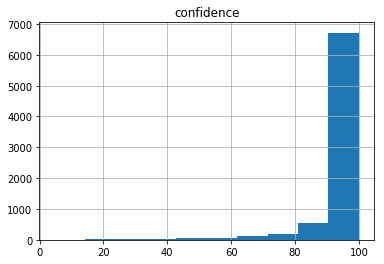

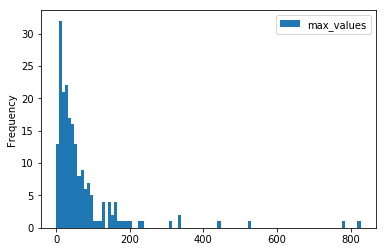

In [261]:
def analyse_records(records_enriched, word_cloud=False):
    

    words_conf = []
    dates = []
    values = []
    #raw data
    for key,data in records_enriched.items():
        
#         print(data['max_value'])
        words_conf = words_conf + data['word_confidences']
        dates = dates + data['dates']
        values.append(data['max_value'])
        
    #let's look at the distribution of confidence scores.    
    df_words = pd.DataFrame(words_conf)
    df_max_values = pd.DataFrame({'max_values':values})
    print('Total Non-unique Tokens {}'.format(df_words.shape[0]))
    
    print('Unique Tokens {}'.format(df_words['word'].unique().shape[0]))
    n = 10
    top_n_terms = df_words['word'].value_counts()[:n].index.tolist()
    print('Top {} Common Tokens {}'.format(n, top_n_terms))
    print('Highest Total Value {} '.format(max(df_max_values['max_values'])))
    print('Lowest Total Value {} '.format(min(df_max_values['max_values'])))
    print('Mean Total Value {} '.format(round(df_max_values['max_values'].mean(),2)))

    df_words.hist()
    df_max_values.plot.hist(bins=100)
    print(df_max_values.describe())
    words_list_non_unique = df_words['word'].tolist()
    
    
    #Simple word cloud to view our data.
    if word_cloud:
        string_of_words = ' '.join(map(str, words_list_non_unique)) 
        wordcloud = WordCloud(
            width = 3000,
            height = 2000,
            background_color = 'black',
            stopwords = STOPWORDS).generate(string_of_words)
        fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.show()

#         df_dates = pd.DataFrame(dates)
#         df_dates.plot()

    return df_words
df_words = analyse_records(records_enriched, word_cloud=False)

### 2.3 Token Co-Occurrence

It might be quite nice to understand the co-occurance of items within receipts.

For those who have worked in this space before, we can used SVD techniques to calculate the co-occurance, or libraries such as GloVe, which uses Vector Spaces of word representations in order to analyse the tokens. 

For this example, we're going to start off with a very simple counter based approach


In [272]:
def token_coocurance(records_enriched, combination_size = 2, min_cooc_cnt = 2):
    
    cooc_counts = {}
    for key,data in records_enriched.items():
        
        tokens = data['tokens']
        cleaned = [ x for x in tokens if (not x.isdigit()) and (len(x)> 2) and (not '.' in x) and (not '/' in x)]
       
        #remove dups
        cleaned =  list(dict.fromkeys(cleaned))
        cooc = list(combinations(cleaned, combination_size)) 
        
        for occ in cooc:
            if occ in cooc_counts:
                cnt = cooc_counts[occ]
                cooc_counts[occ] = cnt +1
            else:
                cooc_counts[occ] = 1
    
    print('Total Unique Token Co-Occurrences {}'.format(len(cooc_counts)))
    cooc_counts_sorted = dict( sorted(cooc_counts.items(), key=operator.itemgetter(1),reverse=True))
    top_k = 50
    cnt = 0
    
   
         
    cooc_counts_sorted_filtered = {key:val for key, val in cooc_counts_sorted.items() if val >= min_cooc_cnt}

    for k,v in cooc_counts_sorted_filtered.items():
            print(k, v)
            
    print('Filtered (min count {}) Unique Token Co-Occurrences {}'.format(min_cooc_cnt, len(cooc_counts_sorted_filtered)))
    return cooc_counts_sorted_filtered

cooc_counts_sorted_filtered = token_coocurance(records_enriched, combination_size = 2, min_cooc_cnt = 2)  

Total Unique Token Co-Occurrences 49491
('parti', 'svrck') 7
('ice', 'tea') 6
('chicken', 'rice') 5
('new', 'york') 5
('settl', 'tender') 4
('diet', 'coke') 4
('avenu', 'side') 4
('acct', 'auth') 4
('mexican', 'chicken') 4
('custom', 'copi') 4
('ave', 'chicken') 4
('chicken', 'beef') 4
('settl', 'creat') 3
('tender', 'creat') 3
('san', 'fernando') 3
('red', 'chicken') 3
('mexican', 'taco') 3
('cafe', 'open') 3
('mac', 'chz') 3
('chees', 'french') 3
('blvd', 'dinner') 3
('chicken', 'guid') 3
('buffet', 'weekend') 3
('buffet', 'dinner') 3
('sauc', 'chip') 3
('debit', 'aid') 3
('salad', 'day') 3
('cheeseburg', 'bacon') 3
('taco', 'asada') 3
('jericho', 'park') 3
('hous', 'wine') 3
('beach', 'cust') 3
('tel', 'cust') 3
('cust', 'chees') 3
('brussel', 'sprout') 3
('wing', 'thing') 3
('wing', 'mac') 3
('wing', 'small') 3
('lafourc', 'alain') 3
('lafourc', 'char') 3
('lafourc', 'eari') 3
('lafourc', 'calss') 3
('lafourc', '02-00-2015') 3
('lafourc', 'note') 3
('lafourc', 'penrter') 3
('lafour

**Notes:** From this data, we could start to build some very primative (and naive) predictive model, which would state. We can see there are some common words that appear to repeat in several of the receipts in our model..

We have already gained some insight into what our data looks like in terms of raw text, as well as distirbution of terms:

- WE know the confidence is on average, high for predicted words
- we know that there is a skewed distribution of total bill costs
- we know that certain items are more popular than others

One of the first things we can do is explore the relationship between the type of food in a receipt, and the overall cost.

### 2.4 Feature Analysis using Co-Occurrence

In order to perform feature analysis, we need to transform our data using One-Hot-Encoding, which essentially means transposing the data where the tokens become columsn, and the values for the columns represent whether the row (receipt) has that value or not.

For instance, we may have a receipt which contains:

- Coffee 
- Toast
- Cake

And in the current data this looks like:

```row{'tokens': ['coffee','toast','cake']}```

However what we want to have is a dataframe (or dict), which looks like 

```row{'coffee':1, 'toast':1, 'cake':1}```

And when we do this for every row, we're going to end up with a LOT of columns (which will be equal to the number of unique tokens we have), thus we need some way to reduce this down, which can either be done by using techniques such as Principle Component Analysis (PCA), or we can do something more simple, such as use our word coocurraence data, and filter by tokens which are within this list, plus, reduce columsn where a Percentage of the columns are 0 (e.g. not present in the receipt).



Total Unqiue words to match against 374
Removing Columns which are all 0 in this group
high_cost (58, 261)
Removed 114 Columns
Columns where 0.1 pct of rows all have values
Remaining Columns ['chicken', 'label', 'shrimp']
Shape of Data Remaining (58, 3)




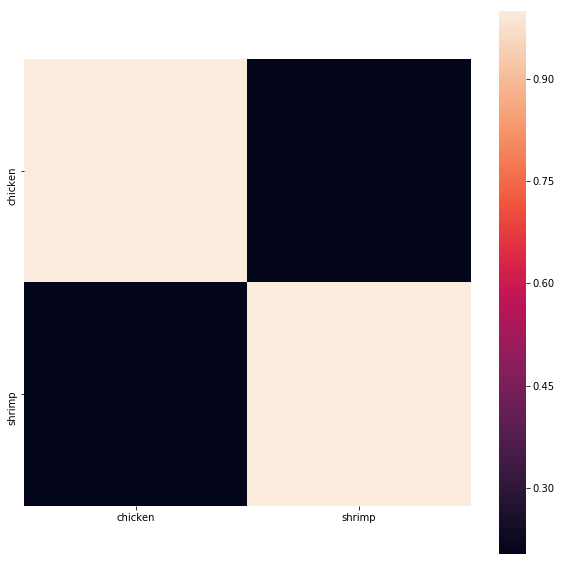

Removing Columns which are all 0 in this group
low_cost (84, 275)
Removed 100 Columns
Columns where 0.1 pct of rows all have values
Remaining Columns ['chees', 'chicken', 'label']
Shape of Data Remaining (84, 3)




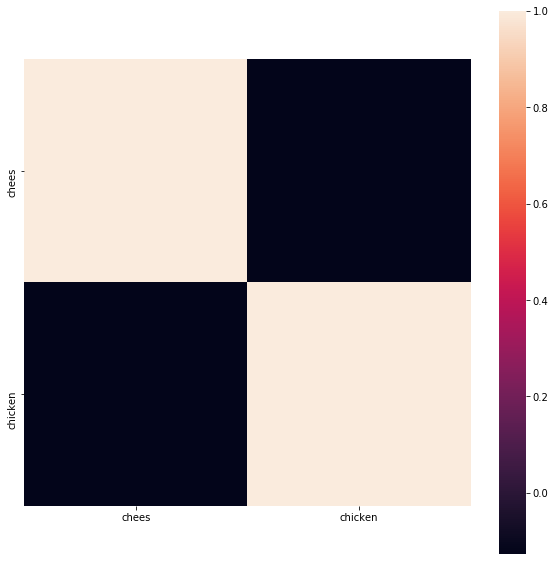

Removing Columns which are all 0 in this group
medium_cost (58, 260)
Removed 115 Columns
Columns where 0.1 pct of rows all have values
Remaining Columns ['beach', 'beef', 'chees', 'chicken', 'coffe', 'coke', 'grill', 'label', 'parti', 'salad', 'shrimp', 'side', 'svrck']
Shape of Data Remaining (58, 13)




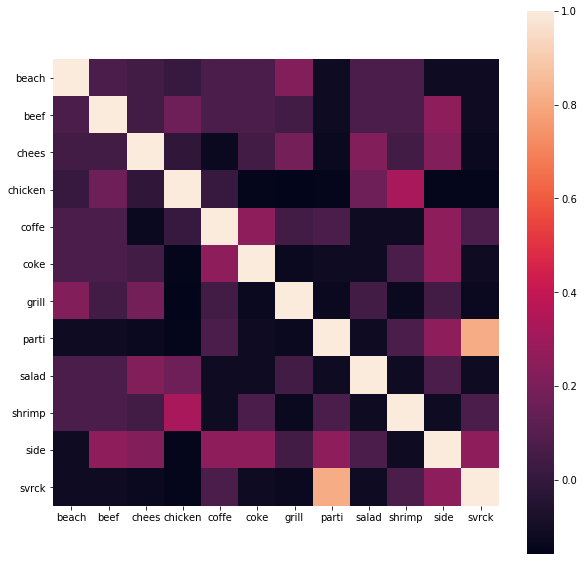

In [299]:
%matplotlib inline

def cost_type(x):
        lower = 0
        lower_thres = 30
        mid_thresh = 67
        
        if x >= lower and x < lower_thres:
            return 'low_cost'
        if x > lower_thres and x < mid_thresh:
            return 'medium_cost'
        if x > mid_thresh:
            return 'high_cost'
        
def food_cost_analysis(records_enriched, cooc_counts_sorted_filtered, pct_not_empty = 0.1):
    
    '''lets use some buckets to group our bills total value
        mean    67.59240
        min      0.000000
        25%     18.825000
        50%     38.545000
        75%     73.265000
    '''
    unique_words_cooc = set()
    for k,v in cooc_counts_sorted_filtered.items():
        unique_words_cooc.add(k[0])
        unique_words_cooc.add(k[1])
        
    print('Total Unqiue words to match against {}'.format(len(unique_words_cooc)))

    
    words_conf = []
    values = []
    #raw data
    rows = []
    dfs_grouped = {}
    for key,data in records_enriched.items():
        
        tmp = {}
        #think one hot encoding
        for token in data['tokens']:
            if (token in unique_words_cooc) and (not token.isdigit()) and (len(token) > 2):
                
                tmp[token] = 1
        
        cost_type_lab = cost_type(data['max_value'])
        tmp['label'] = cost_type_lab
        rows.append(tmp)
#         break

    df_features = pd.DataFrame(rows)
    df_features = df_features.fillna(0)
    df_features = df_features[df_features['label'] !=0]
    columns = list(df_features.columns)
    
    #now let's group by label type
    for name,group in df_features.groupby('label'):
        cleaned_group =  group.loc[(group).any(1), (group!=0).any(0)]
        print('Removing Columns which are all 0 in this group')
        print(name, cleaned_group.shape)
        cols = list(cleaned_group.columns)
        cut_cols  = list(set(columns) - set(cols))
        print('Removed {} Columns'.format(len(cut_cols)))
        
        tmp = group.replace([0,' ','NULL'],np.nan)
        common_feats = tmp.dropna(thresh=tmp.shape[0]*pct_not_empty,how='all',axis=1) 
        common_feats = common_feats.fillna(0)

        print('Columns where {} pct of rows all have values'.format(pct_not_empty))
        print('Remaining Columns {}'.format(list(common_feats.columns)))
        print('Shape of Data Remaining {}'.format(common_feats.shape))
        print('\n')
        dfs_grouped[cost_type_lab] = common_feats
        
        corrs = common_feats.corr()
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(corrs, square=True)
        plt.show()

        
        
food_cost_analysis(records_enriched,cooc_counts_sorted_filtered, pct_not_empty=0.1)           

**Notes:** From the analysis, we can see that depending on the cost of the bill (which has be set based on the distribution of receipt max_values that we initially analysed), the type and number of items within buckets (low, medium, high), changes.

Adjusting the pct_not_empty to a smaller value, and also increasing the size of the word co-occurence list will increase the number of columns within the datasets, however, this may not have a positive impact on understanding the feature space, given that this brute force approach is trying to identify features which have importance on the bill cost.



### 2.5 Word Embeddings 

Another approach is to examine the word embeddings of the text in order to determine relationships between the terms (tokens) within the data.

Word2Vec is a popular algorithm used for generating dense vector representations of words in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.

In order to acheive this, we're going to be using SageMaker's ```blazingtext``` estimator.



In [169]:
def prep_data_form_sagemaker_training(configs, global_vars, records_enriched):
    
    tokens = []
    #raw data
    for key,data in records_enriched.items():
        
#         print(data['max_value'])
        tokens = tokens + data['tokens']
    
    cleaned = [ x for x in tokens if (not x.isdigit()) and (len(x)> 2) ]

    corpus = ' '.join(map(str, cleaned)) 
    print('Total Corpus Size: {} Tokens'.format(len(tokens)))
    print('Total Char Size: {} '.format(len(corpus)))
    
    return corpus
    
    
corpus = prep_data_form_sagemaker_training(configs, global_vars, records_enriched)    

Total Corpus Size: 8956 Tokens
Total Char Size: 44707 


In [170]:
def upload_corpus_to_s3(configs, global_vars, corpus):
    
         
    dataset_key = 'train'
    s3_bucket = global_vars['s3_bucket']
    
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
    
    with open(dataset_key, 'w') as f:
        f.write(corpus)
   
        
    data_file_s3 = configs['training_data_prefix_s3'] + dataset_key
    s3_bucket.upload_file(dataset_key, data_file_s3)   

    s3_train_data = 's3://{}/{}'.format(configs['bucket_name'], configs['training_data_prefix_s3'])
    s3_output_location = 's3://{}/output'.format(configs['bucket_name'])
    configs['s3_train_data'] = s3_train_data
    configs['s3_output_location'] = s3_output_location

    print('S3 Training Data Path {}'.format(s3_train_data))
    print('S3 Training Data Path {}'.format(s3_output_location))

    return configs
configs = upload_corpus_to_s3(configs, global_vars, corpus) 

S3 Training Data Path s3://aws-demo-receipts/training_data/
S3 Training Data Path s3://aws-demo-receipts/output


In [171]:
def configure_estimator(configs, global_vars):
    
    region_name = configs['aws_region'] 
    sess = global_vars['sess']
    container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
    print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

    bt_model = sagemaker.estimator.Estimator(container,
                                         global_vars['role'], 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=configs['s3_output_location'],
                                         sagemaker_session=sess)
    
    bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram
    
    train_data = sagemaker.session.s3_input(configs['s3_train_data'], distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

    data_channels = {'train': train_data}
    
   
    global_vars['train_data'] = train_data
    global_vars['data_channels'] = data_channels
    global_vars['bt_model'] = bt_model
    
    return global_vars

global_vars = configure_estimator(configs, global_vars)

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [ ]:
def fit_model(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    data_channels = global_vars['data_channels']
    bt_model.fit(inputs=data_channels, logs=True)
    
    
fit_model(configs, global_vars)

2020-03-18 08:36:38 Starting - Starting the training job...
2020-03-18 08:36:42 Starting - Launching requested ML instances......
2020-03-18 08:37:45 Starting - Preparing the instances for training...
2020-03-18 08:38:37 Downloading - Downloading input data......
2020-03-18 08:39:23 Training - Training image download completed. Training in progress.Arguments: train
Arguments: train
Found 10.2.182.94 for host algo-1
Found 10.2.129.203 for host algo-2
Found 10.2.182.94 for host algo-1
Found 10.2.129.203 for host algo-2
[03/18/2020 08:39:37 WARNING 140172897224512] Loggers have already been setup.
[03/18/2020 08:39:37 WARNING 140172897224512] Loggers have already been setup.
[03/18/2020 08:39:37 INFO 140172897224512] nvidia-smi took: 0.0251920223236 secs to identify 0 gpus
[03/18/2020 08:39:37 INFO 140172897224512] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[03/18/2020 08:39:37 INFO 140172897224512] Number of hosts: 2, master IP address: 10.2.182.94, hos

In [174]:
def host_endpoint(configs, global_vars):
        
    bt_model = global_vars['bt_model']

    bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

    global_vars['bt_endpoint']  = bt_endpoint 
    return global_vars
    
# global_vars = host_endpoint(configs, global_vars)

In [175]:
def download_model_results(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    s3 = global_vars['s3']
    bucket_name = configs['bucket_name']
    model_filename = 'model.tar.gz'
    key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
    s3.Bucket(bucket_name).download_file(key, model_filename )

    #untar file
    tar = tarfile.open(model_filename)
    tar.extractall()
    tar.close()

download_model_results(configs, global_vars)


In [179]:
def evaluate_model_results():
    num_points = 149

    first_line = True
    index_to_word = []
    cnt  = 0
    with open("vectors.txt","r") as f:
        for line_num, line in enumerate(f):
            if first_line:
                dim = int(line.strip().split()[1])
                word_vecs = np.zeros((num_points, dim), dtype=float)
                first_line = False
                continue
            line = line.strip()
            word = line.split()[0]
            vec = word_vecs[line_num-1]
            for index, vec_val in enumerate(line.split()[1:]):
                vec[index] = float(vec_val)
            index_to_word.append(word)
            if line_num >= num_points:
                break
            cnt +=1
    word_vecs = normalize(word_vecs, copy=False, return_norm=False)
    print('Total Vector Space {}'.format(cnt))

    tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=10000, verbose=1)
    two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
    labels = index_to_word[:num_points]
    
    print('Total Tokens {}'.format(len(labels)))
    
    return two_d_embeddings, labels

two_d_embeddings, labels = evaluate_model_results()

Total Vector Space 148
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 149 samples in 0.000s...
[t-SNE] Computed neighbors for 149 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 149 / 149
[t-SNE] Mean sigma: 0.172941
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.734451
[t-SNE] KL divergence after 2750 iterations: 1.623223
Total Tokens 149


#### Plotting Embeddings
 t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look the same everytime the methods are executed

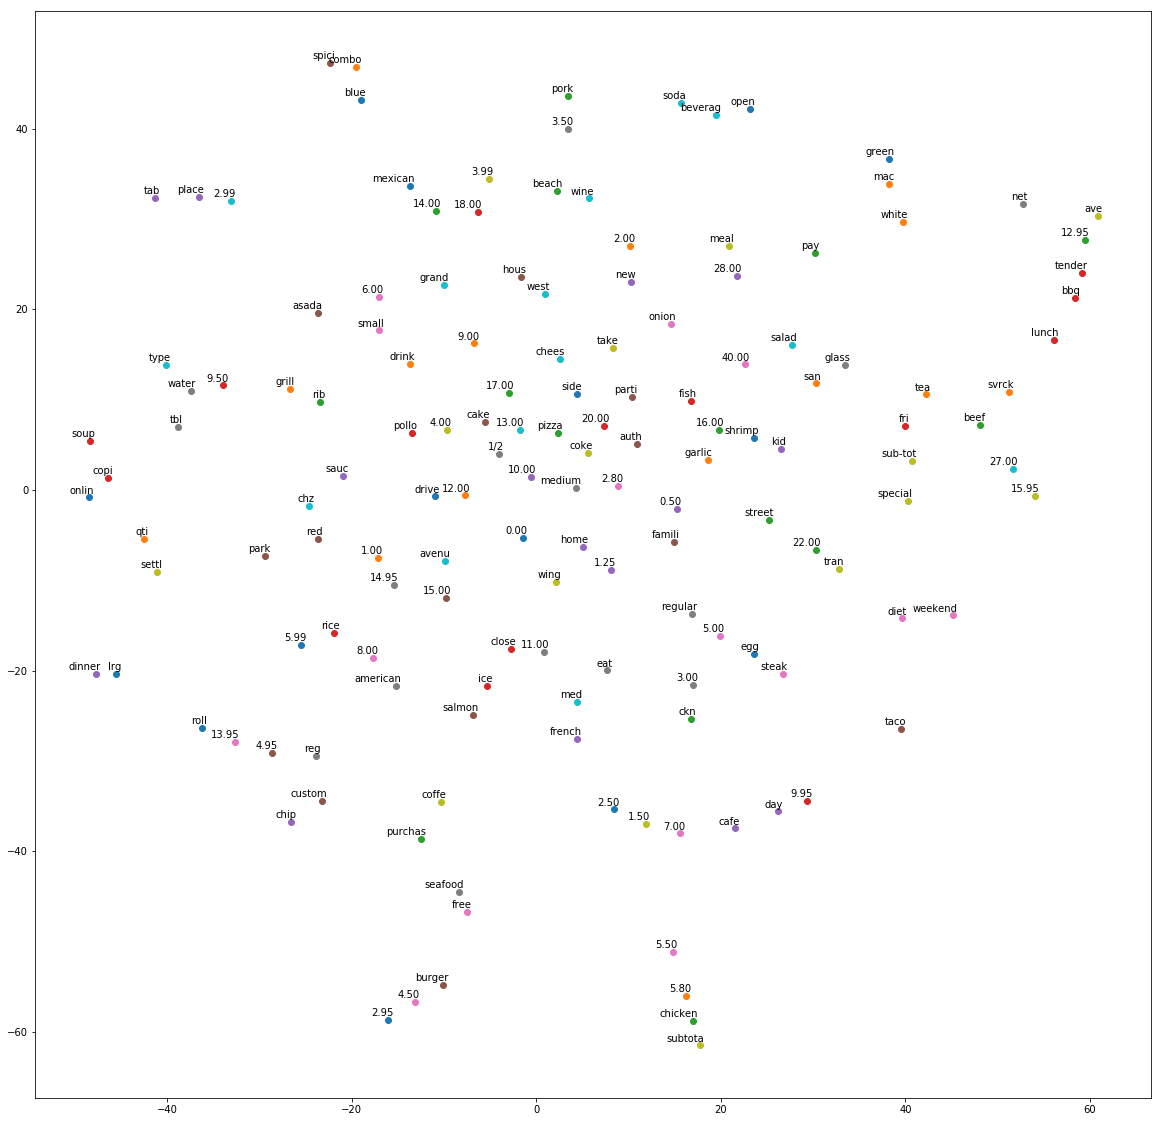

In [180]:
def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

Notes: Compared to the Word Co-Occurence Approach, work embeddings usign Skip-Grams provide an abstraction of tokens within a given vector space, which allows for relationships between different words to be exposed! We can see from the results, we are seeing words such as Pasta, Pizza, and Cheese occuring within the same vector space, for instance. Pretty good considering the tokens used to build our embeddings was extremely small!
